# MDAnalysis

In [1]:
import MDAnalysis as mda
import nglview as nv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.spatial.distance as ssd
from scipy import constants
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import KernelDensity

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout as layout

import seaborn as sns

import time
import random

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

In [3]:
print(mda.__version__)
print(nv.__version__)

2.1.0
3.0.3


In [4]:
print(nx.__version__)

2.4


### Load the LAMMPS files

In [5]:
LAMMPSDATA = 'lmp.data'
u = mda.Universe(LAMMPSDATA, atom_style="id resid type charge x y z")
#traj_list = ['trajectory.0.xtc', 'trajectory.1.xtc', 'trajectory.2.xtc', 'trajectory.3.xtc', 'trajectory.4.xtc', 'trajectory.5.xtc', 'trajectory.6.xtc', 'trajectory.7.xtc', 'trajectory.8.xtc', 'trajectory.9.xtc', 'trajectory.10.xtc', 'trajectory.11.xtc', 'trajectory.12.xtc', 'trajectory.13.xtc', 'trajectory.14.xtc', 'trajectory.15.xtc', 'trajectory.16.xtc']
traj_list = ['trajectory.11.xtc', 'trajectory.12.xtc', 'trajectory.13.xtc', 'trajectory.14.xtc', 'trajectory.15.xtc', 'trajectory.16.xtc']
%time u.load_new(traj_list)
#%time u.load_new('trajectory.16.xtc')
print(u.trajectory)

CPU times: user 45.5 ms, sys: 6.64 ms, total: 52.1 ms
Wall time: 57.4 ms
<ChainReader containing trajectory.11.xtc and 5 more with 96885 frames of 18500 atoms>


/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 1
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 2
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 3
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 4
  warnings.warn("Failed to guess the mass for the f

### Select the atoms of interest

In [6]:
calcium = u.select_atoms('type 1')
carbon = u.select_atoms('type 2')
ionclusters = u.select_atoms('type 1 2')
carbonate = u.select_atoms('type 2 4')
wateroxygen = u.select_atoms('type 5')
water = u.select_atoms('type 3 5')

In [7]:
u.trajectory

<ChainReader containing trajectory.11.xtc and 5 more with 96885 frames of 18500 atoms>

### Set the atom charges and masses

In [8]:
# Atomic masses
mca = 40.078
mc = 12.0107
mo = 15.9994
mh = 1.0079

calcium.masses = mca
carbon.masses = mc
carbonate.masses = mc + 3*mo
wateroxygen.masses = mo
water.masses = mo + 2*mh

# Gale force field charges
qca = 2.0000
qc4 = 1.123285
qo4 = -1.041095
qo2 = -0.820000
qh2 = 0.410000

calcium.charges = qca
carbon.charges = qc4
carbonate.charges = qc4 + 3*qo4
wateroxygen.charges = qo2
water.charges = qo2 + 2*qh2

### Calculate a RDF

In [9]:
'''
from MDAnalysis.analysis import rdf
irdf = rdf.InterRDF(calcium, carbon,
                    nbins=150,  # default
                    range=(0.0, 10.0),  # distance in angstroms
                   )
%time irdf.run()
'''

'\nfrom MDAnalysis.analysis import rdf\nirdf = rdf.InterRDF(calcium, carbon,\n                    nbins=150,  # default\n                    range=(0.0, 10.0),  # distance in angstroms\n                   )\n%time irdf.run()\n'

### Plot the FE

In [10]:
''' 
# Define thermal energy
kT = constants.R*298/1000

# Boltzmann invert and plot
pmf = -kT*np.log(irdf.rdf)
plt.plot(irdf.bins, pmf)
plt.plot([0 ,21],[0,0],'--')
plt.xlabel('Radius (Angstrom)')
plt.ylabel('Potential of Mean Force (kJ/mol)')

# Check the truncation distance for inner sphere contacts based on the pmf
delta = irdf.bins[1] - irdf.bins[0]
bcutoff = int(5.0/delta) # Set the maximum distance for the truncation

# Identify and report the first minimum
pmfmin = np.argwhere(pmf == np.amin(pmf[1:bcutoff]))
print("First PMF minimimum",np.amin(pmf[1:bcutoff]),irdf.bins[pmfmin])

# Identify and report the first maximum
pmfmax = np.amax(pmf[np.int(pmfmin):bcutoff*2])
truncation = np.argwhere(pmf == pmfmax)
print("Truncation distance in Angstroms",irdf.bins[truncation])
'''

' \n# Define thermal energy\nkT = constants.R*298/1000\n\n# Boltzmann invert and plot\npmf = -kT*np.log(irdf.rdf)\nplt.plot(irdf.bins, pmf)\nplt.plot([0 ,21],[0,0],\'--\')\nplt.xlabel(\'Radius (Angstrom)\')\nplt.ylabel(\'Potential of Mean Force (kJ/mol)\')\n\n# Check the truncation distance for inner sphere contacts based on the pmf\ndelta = irdf.bins[1] - irdf.bins[0]\nbcutoff = int(5.0/delta) # Set the maximum distance for the truncation\n\n# Identify and report the first minimum\npmfmin = np.argwhere(pmf == np.amin(pmf[1:bcutoff]))\nprint("First PMF minimimum",np.amin(pmf[1:bcutoff]),irdf.bins[pmfmin])\n\n# Identify and report the first maximum\npmfmax = np.amax(pmf[np.int(pmfmin):bcutoff*2])\ntruncation = np.argwhere(pmf == pmfmax)\nprint("Truncation distance in Angstroms",irdf.bins[truncation])\n'

### Loop through the frames and identify the droplet (largest cluster)

In [95]:
from MDAnalysis.analysis.distances import contact_matrix
import MDAnalysis.transformations as trans

# Set the cutoff for first sphere coordination
trunc_distance = 4.0#irdf.bins[truncation] 

# Scaling factors
molarity_scaling = 1e+27/constants.Avogadro
molal_scaling = 1/((len(wateroxygen)*water.masses[0]/1000))

# Plotting arrays
time = [] # simulation time
ncls = [] # number of clusters
clsz = [] # cluster sizes
dsiz = [] # droplet size
dchg = [] # droplet charge
drgy = [] # droplet radius of gyration
ccat = [] # cation concentration
cani = [] # cation concentration
cdim = []
ctet = []
chex = []
bcat = [] # cation molality
bani = [] # cation molality

frames = 0
# Loop through the frames
for ts in u.trajectory[0:-1:100]:
    
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(ionclusters.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)

    # Generate a graph from the adjacency matrix
    Graph = nx.Graph(adjmatrix)
    
    # Size of connected components in the graph
    cluster_size = [len(c) for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    largest_cluster_size = cluster_size[0]

    # Number of connected components
    number_of_clusters = len(cluster_size)    
    
    # List of nodes in every connected component
    cluster_members = [c for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    

    # Get the components of the largest cluster
    largest_cluster_indices = list(cluster_members[0])
    droplet = u.atoms[(ionclusters.indices[largest_cluster_indices])]
                      
    # PROPERTIES OF THE DROPLET
    droplet_charge = droplet.total_charge()
    droplet_center = droplet.center_of_mass(wrap=True)
    droplet_rgyr = droplet.radius_of_gyration(wrap=True)
    
    # PROPERTIES OF THE SOLUTION
    monomer_charges = [] 
    monomer_indices = np.argwhere(np.array(cluster_size) == 1)
    
    # Get the dispersed ions
    for i in range(0,monomer_indices.size):      
        at = list(cluster_members[np.int(monomer_indices[i])]) # ion index

        monomer_charges.append(u.atoms[at].charges)
        
    # Count the number of positive and negative ions
    number_cations = np.sum(np.array(monomer_charges) > 0)
    number_anions = np.sum(np.array(monomer_charges) < 0)
    concn_cations = number_cations/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    concn_anions = number_anions/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    molal_cations = number_cations*molal_scaling*1000 #mmol
    molal_anions = number_anions*molal_scaling*1000 #mmol
    
    dims = np.sum(np.array(cluster_size) == 2)
    tets = np.sum(np.array(cluster_size) == 4)
    hexs = np.sum(np.array(cluster_size) == 6)
    cdim.append(dims/ts.dimensions[0]**3*molarity_scaling)
    ctet.append(tets/ts.dimensions[0]**3*molarity_scaling)
    chex.append(hexs/ts.dimensions[0]**3*molarity_scaling)
    
    # Report the time series cluster information
    #print(ts.time,number_of_clusters,largest_cluster_size, droplet_charge, 
    #      droplet_rgyr, number_cations, number_anions, molal_cations,
    #     molal_anions)    

    # Record the data for plotting
    time.append(ts.time/1000)
    ncls.append(number_of_clusters)
    clsz.extend(cluster_size[:])
    dsiz.append(largest_cluster_size)
    dchg.append(droplet_charge)
    drgy.append(droplet_rgyr/10)
    ccat.append(concn_cations)
    cani.append(concn_anions)
    bcat.append(molal_cations)
    bani.append(molal_anions)
    
    
    frames += 1

### Plot the cluster size distribution

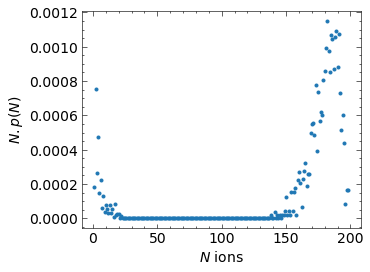

In [96]:

clsz = np.array(clsz)
histmin = np.amin(clsz)
histmax = np.amax(clsz)
xaxis = np.arange(1,histmax+1)
bins = xaxis.size

hist, bin_edges = np.histogram(clsz, density=True, bins=bins)
plt.ylabel("$N.p(N)$")
plt.xlabel("$N$ ions")
#plt.plot(xaxis,(hist/frames)*xaxis,'k-',linewidth=1)
plt.plot(xaxis,(hist/frames)*xaxis,'o',markersize=pms)

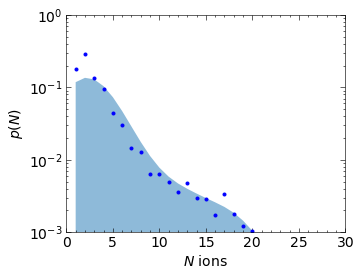

In [97]:
from scipy import stats

lim=30

kernel = stats.gaussian_kde(clsz,bw_method=0.01)
plt.plot(xaxis[:lim],kernel(xaxis)[:lim],'bo',markersize=pms)

from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=2, kernel='gaussian')
kde.fit(clsz[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(xaxis[:, None])

plt.fill_between(xaxis[:lim], np.exp(logprob)[:lim], alpha=0.5)


plt.ylabel("$p(N)$")
plt.xlabel("$N$ ions")
plt.yscale("log")
plt.xlim(0,lim)
plt.ylim(0.001,1)
plt.savefig('pN.png',dpi=300)

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


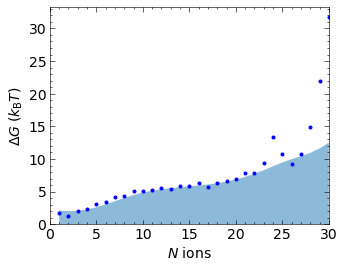

In [70]:
fe1 = -np.log(kernel(xaxis))
fe2 = -np.log(np.exp(logprob))

plt.plot(xaxis[:lim],fe1[:lim],'bo',markersize=pms)
plt.fill_between(xaxis[:lim], fe2[:lim], alpha=0.5)

plt.xlim(0,lim)
plt.ylim(0,)
plt.ylabel("$\Delta G \;(k_\mathrm{B}T)$")
plt.xlabel("$N$ ions")
plt.savefig('FE.png',dpi=300)

### Ks from probabilities

In [103]:
pdimers = kernel(xaxis)[1]
ptetramers = kernel(xaxis)[3]
phexamers = kernel(xaxis)[5]

K1 = pdimers/(kernel(xaxis)[0])
K2 = ptetramers/(pdimers)#*pdimers)
K3 = phexamers/(pdimers)#*pdimers*pdimers)
print(K1,K2,K3)

1.6145884718588774 0.3368660708426784 0.10725904161497474


### Ks from concentrations

In [106]:
catcon = np.mean(ccat)/1000
cancon = np.mean(cani)/1000
dimcon = np.mean(cdim)
tetcon = np.mean(ctet)
hexcon = np.mean(chex)

print(catcon*1000,cancon*1000,dimcon*1000,tetcon*1000,hexcon*1000)

0.7997373855565556 11.676514267843341 25.87801581394247 8.157681527068807 2.574691884740659


In [115]:
K1 = dimcon/(catcon*cancon)
print('K1',K1)
K2 = tetcon/dimcon**2
print('K2',K2)
#K2 = tetcon/(catcon*cancon*catcon*cancon)
#print('K2',K2)
K3 = hexcon/dimcon**3
print('K3',K3)
#K3 = hexcon/(dimcon*tetcon)
#print('K3',K3)
#K3 = hexcon/(catcon*cancon*catcon*cancon*catcon*cancon)
#print('K3',K3)
print(-2.479*np.log(K1),-2.479*np.log(K2),-2.479*np.log(K3))

K1 2771.215892813785
K2 12.181613015782139
K3 148.57041702040695
-19.6511357628425 -6.197320731171223 -12.39762534662574


### Plots

Text(0.5, 0, 'time (ns)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


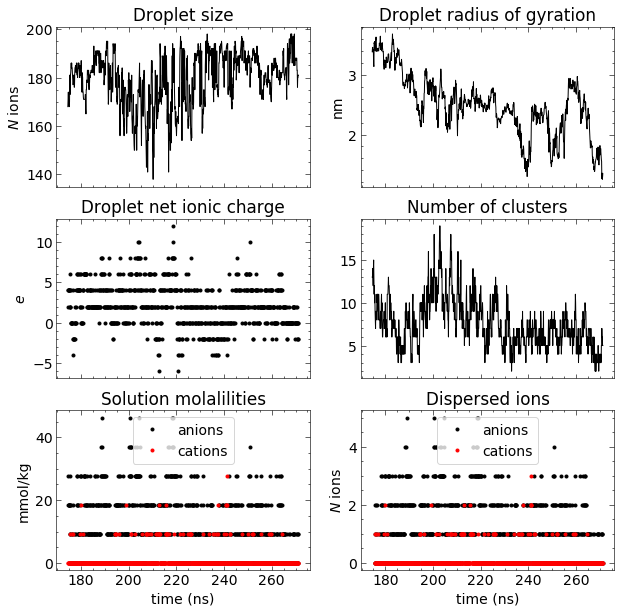

In [15]:
fig, [[ax0, ax1], [ax2, ax3], [ax4, ax5]] = plt.subplots(nrows=3, ncols=2, sharex=True,figsize=(10,10))  

# Droplet size
#ax0.set_xlim([intzmin+1.5,intzmax-0.1])
#ax0.set_ylim([0,2.5])
ax0.title.set_text('Droplet size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,dsiz,'k-',linewidth=1)

# Radius of gyration
#ax1.set_xlim([intzmin,intzmax-0.1])
#ax1.set_ylim([0,1.05])
ax1.title.set_text('Droplet radius of gyration')
ax1.set_ylabel("nm")
ax1.plot(time,drgy,'k-',linewidth=1)

# Droplet net ionic charge
#ax2.set_xlim([intzmin,intzmax-0.1])
#ax2.set_ylim([-1,1])
ax2.title.set_text('Droplet net ionic charge')
ax2.set_ylabel("$e$")
ax2.plot(time,dchg,'ko',markersize=pms)

# Number of clusters
#ax3.set_xlim([intzmin,intzmax-0.1])
#ax3.set_ylim([0,2.5])
ax3.title.set_text('Number of clusters')
ax3.set_ylabel("")
ax3.plot(time,ncls,'k-',linewidth=1)

# Free ion molalities
#ax4.set_xlim([intzmin,intzmax-0.1])
#ax4.set_ylim([0,2.5])
ax4.title.set_text('Solution molalilities')
ax4.set_ylabel("mmol/kg")
ax4.plot(time[1:-1],bani[1:-1],'ko',markersize=pms, label='anions')
ax4.plot(time[1:-1],bcat[1:-1],'ro',markersize=pms, label='cations')
legend = ax4.legend(loc='upper center')
ax4.set_xlabel("time (ns)")

# Free ion molalities
#ax4.set_xlim([intzmin,intzmax-0.1])
#ax4.set_ylim([0,2.5])
ax5.title.set_text('Dispersed ions')
ax5.set_ylabel("$N$ ions")
ax5.plot(time[10:-1],np.array(bani[10:-1])/(molal_scaling*1000),'ko',markersize=pms, label='anions')
ax5.plot(time[10:-1],np.array(bcat[10:-1])/(molal_scaling*1000),'ro',markersize=pms, label='cations')
legend = ax5.legend(loc='upper center')
ax5.set_xlabel("time (ns)")


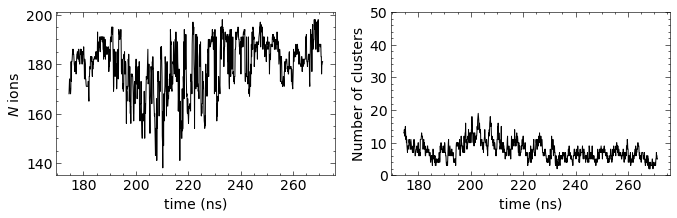

In [16]:
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, sharex=False,figsize=(11,3))  

# Droplet size
#ax0.set_xlim([intzmin+1.5,intzmax-0.1])
#ax0.set_ylim([0,2.5])
#ax0.title.set_text('Droplet size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,dsiz,'k-',linewidth=1)
ax0.set_xlabel("time (ns)")

# Number of clusters
#ax3.set_xlim([intzmin,intzmax-0.1])
ax1.set_ylim([0,50])
#ax3.title.set_text('Number of clusters')
ax1.set_ylabel("Number of clusters")
ax1.plot(time,ncls,'k-',linewidth=1)
ax1.set_xlabel("time (ns)")

plt.savefig('timeseries.png',dpi=300)

### Average ion molalities

In [17]:
print(np.mean(bani),np.std(bani),np.mean(bani)/(molal_scaling*1000),np.std(bani)/(molal_scaling*1000))

11.56192180366194 9.591586050572666 1.2497420020639836 1.0367660461096602


In [18]:
print(np.mean(bcat),np.std(bcat),np.mean(bcat)/(molal_scaling*1000),np.std(bani)/(molal_scaling*1000))

0.7924355984343031 2.940480394329842 0.08565531475748195 1.0367660461096602
